## ***Imports***

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [39]:
import keras
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


## ***Exploratory Data Analysis***

In [49]:
len(os.listdir(r"D:\IIT BBS\Intern works\Side Projects & interests\Computer Vision\Defective Leaf Detection\image data\train")) #Add augmented train folder here

44

## ***Data Preprocessing***
***Using MobileNet-V3***

In [50]:
# Data generators
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input, decode_predictions

# Data generators
train_datagen = ImageDataGenerator(zoom_range=0.5, 
                                   shear_range=0.3,  
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [51]:
train = train_datagen.flow_from_directory(directory=r"D:\IIT BBS\Intern works\Side Projects & interests\Computer Vision\Defective Leaf Detection\image data\train",
                                          target_size=(256,256),
                                          batch_size=32)

val = val_datagen.flow_from_directory(directory=r"D:\IIT BBS\Intern works\Side Projects & interests\Computer Vision\Defective Leaf Detection\image data\validation",
                                      target_size=(256,256),
                                      batch_size=32)

Found 38104 images belonging to 44 classes.
Found 9458 images belonging to 44 classes.


In [52]:
t_img, label = next(train)

In [53]:
t_img.shape

(32, 256, 256, 3)

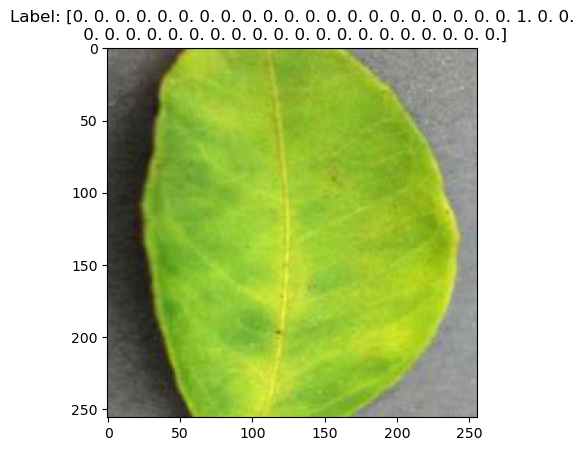

In [54]:
# Reverse the preprocessing to display the image correctly
t_img_display = t_img[0].copy()
t_img_display = t_img_display - np.min(t_img_display)
t_img_display = t_img_display / np.max(t_img_display)

# Display the first image and its label
plt.imshow(t_img_display)
plt.title(f'Label: {label[0]}')
plt.show()

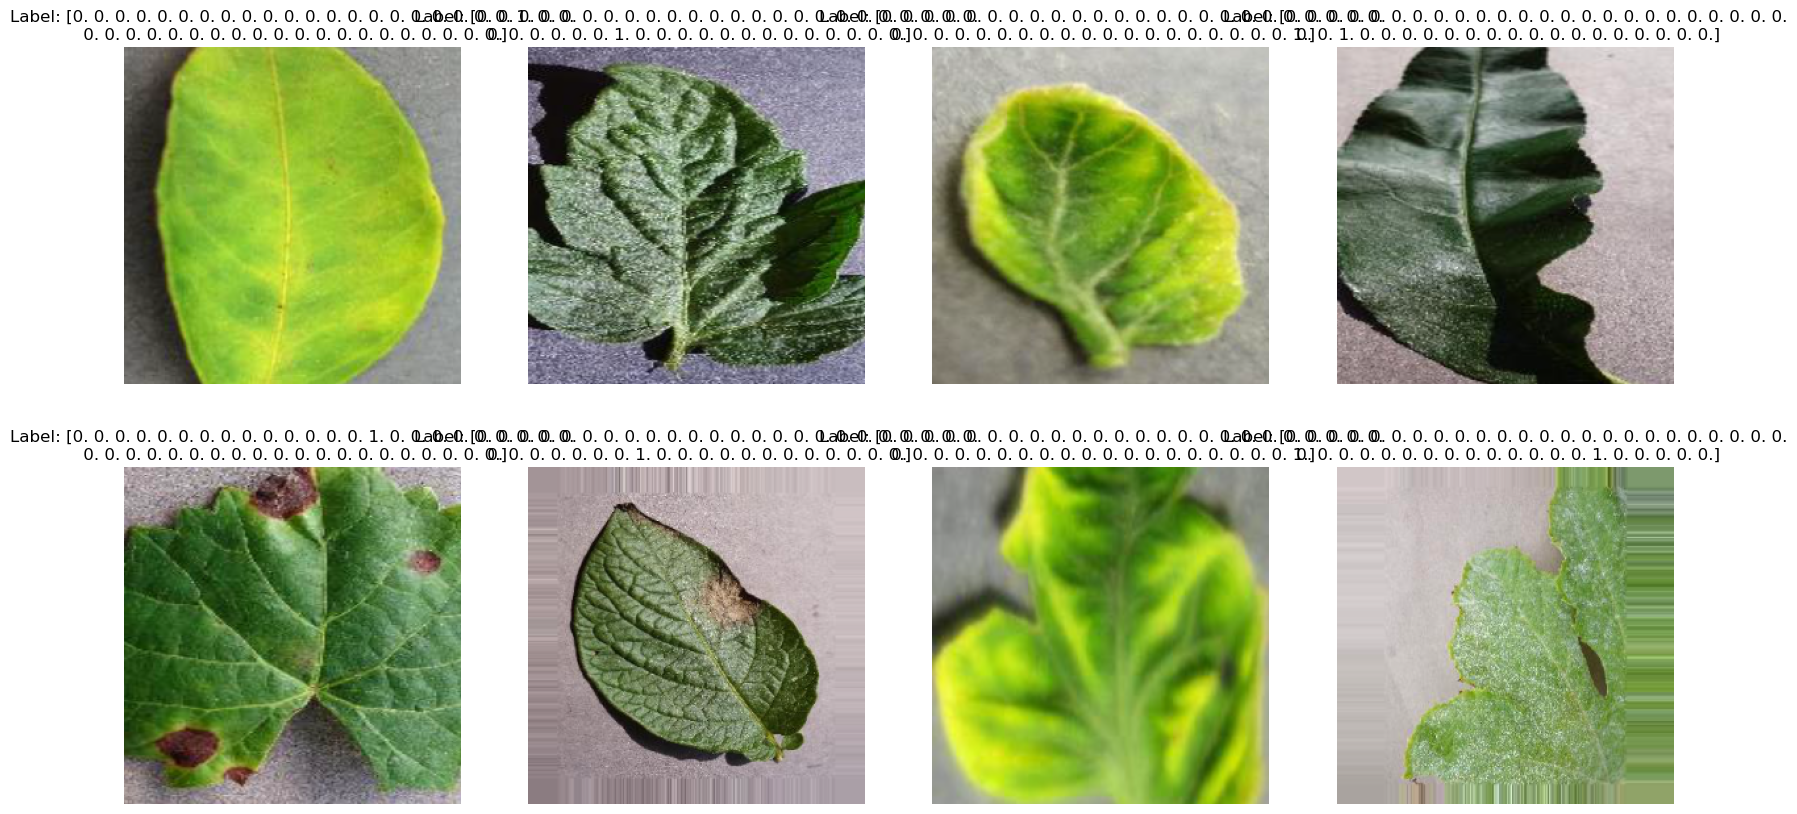

In [55]:
# Reverse the preprocessing to display the images correctly
def reverse_preprocessing(img):
    img = img.copy()
    img = img - np.min(img)
    img = img / np.max(img)
    return img

num_images = 8
plt.figure(figsize=(20, 10))
for i in range(num_images):
    img = reverse_preprocessing(t_img[i])
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Label: {label[i]}')
    plt.axis('off')
plt.show()

## ***Building the Model***

In [56]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
import keras

In [57]:
base_model = MobileNetV3Small(input_shape=(256,256,3),include_top=False)

d:\Anaconda\envs\Defective_Leaf_Detection\Lib\site-packages\keras\src\applications\mobilenet_v3.py:449: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [58]:
for layer in base_model.layers:
    layer.trainable = False

In [60]:
base_model.summary()

Model: "MobilenetV3small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 128, 128,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 129, 129,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 64, 64,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        256 │ expanded_conv_sq

 Total params: 939,120 (3.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 939,120 (3.58 MB)

In [61]:
X = Flatten()(base_model.output)
X = Dense(units=44, activation='softmax')(X)

# Creating the model
model = Model(base_model.input, X)

In [62]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 128, 128,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 128, 128,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 129, 129,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 64, 64,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        256 │ expanded_conv_sq

 Total params: 2,561,180 (9.77 MB)

 Trainable params: 1,622,060 (6.19 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [67]:
model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

## ***Early Stopping & Model Checkpoint***

In [66]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Early stopping 
es = EarlyStopping(monitor = 'val_accuracy', 
                   min_delta=0.01, 
                   patience = 3,
                   verbose=1)

# model checkpoint
mc = ModelCheckpoint(filepath = "best_model.keras", 
                     monitor = 'val_accuracy', 
                     verbose=1,
                     save_best_only=True)

cb = [es,mc]

In [69]:
his = model.fit(train, 
                steps_per_epoch=16,
                epochs=50,
                verbose=1,
                callbacks=cb,
                validation_data=val,
                validation_steps=16)

Epoch 1/50


d:\Anaconda\envs\Defective_Leaf_Detection\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.1735 - loss: 10.1977
Epoch 1: val_accuracy improved from -inf to 0.49023, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.1789 - loss: 10.1915 - val_accuracy: 0.4902 - val_loss: 5.2852
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.5008 - loss: 5.5480
Epoch 2: val_accuracy improved from 0.49023 to 0.55664, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5012 - loss: 5.5289 - val_accuracy: 0.5566 - val_loss: 4.8130
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.5609 - loss: 4.9734
Epoch 3: val_accuracy improved from 0.55664 to 0.70898, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5630 - loss: 4.9513 - val_accuracy: 0.7090 - val_loss: 2.9571
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.6326 - loss: 4.6308
Epoch 4: val_accuracy did not improve from 0.70898
16/16

In [70]:
h = his.history
h.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

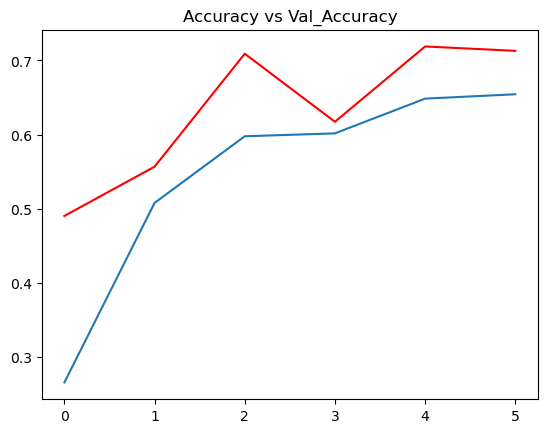

In [71]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c="red")
plt.title('Accuracy vs Val_Accuracy')
plt.show()

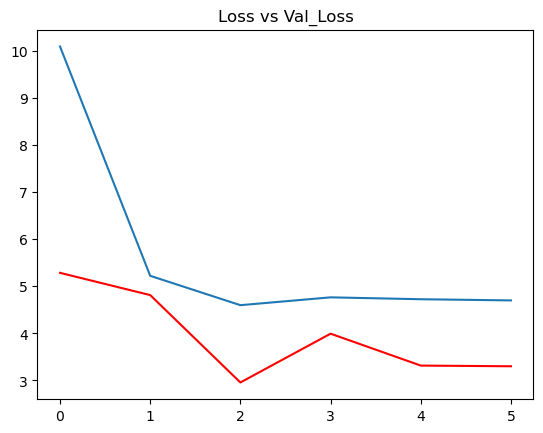

In [72]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c="red")
plt.title('Loss vs Val_Loss')
plt.show()

In [73]:
from keras.models import load_model
model = load_model(r"best_model.keras")

In [75]:
acc = model.evaluate(val)[1]
print(f'The accuracy of the model is {acc*100}%')

296/296 ━━━━━━━━━━━━━━━━━━━━ 95s 315ms/step - accuracy: 0.7159 - loss: 3.5924
The accuracy of the model is 71.46331071853638%


## ***Testing with new Image***

In [97]:
ref = dict(zip(list(train.class_indices.values()),
    list(train.class_indices.keys())))

In [98]:
def prediction(path):
    img = load_img(path,
                   target_size=(256,256))
    i = img_to_array(img)
    im = preprocess_input(i)
    # print(im, im.shape)
    img = np.expand_dims(im , axis=0)
    # print(img.shape)
    pred = np.argmax(model.predict(img))
    print(f'The Image Belongs to {ref[pred]}')

In [101]:
# bacterial spot tomato
path = r"D:\IIT BBS\Intern works\Side Projects & interests\Computer Vision\Defective Leaf Detection\image data\test\bacterial spot tomato\0ab41c2e-c6fc-4ef1-9ffb-ce1b241d32be___GCREC_Bact.Sp 3426.JPG"
prediction(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
The Image Belongs to bacterial spot tomato


In [102]:
# Mosaic Disease (CMD) Cassava
path = r"D:\IIT BBS\Intern works\Side Projects & interests\Computer Vision\Defective Leaf Detection\image data\test\Mosaic Disease (CMD) Cassava\112818929.jpg"
prediction(path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
The Image Belongs to Healthy Cassava
